This file is used to dig deeper into understanding why I see some distances from the ball for some positions that don't seem possible. (See figure 1 plot generated from tracking_eda.ipynb)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


Figure 1 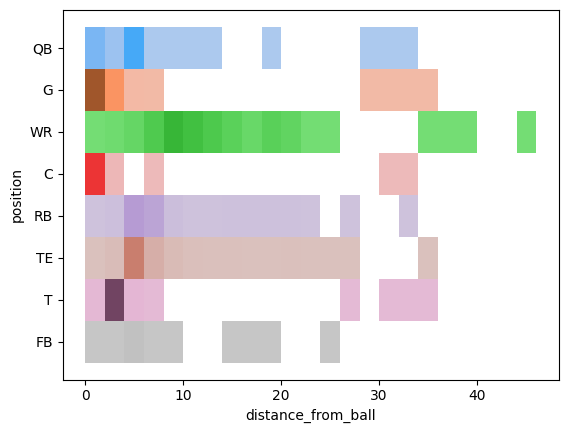

In [12]:
df = pd.read_csv('./data/tracking_week_1.csv')
play_df = pd.read_csv('./data/plays.csv')
players = pd.read_csv('./data/players.csv')

formation_df = df[df['event'] == 'ball_snap']
football_positions = formation_df[formation_df['displayName'] == 'football'][['gameId', 'playId', 'frameId', 'x', 'y']]
football_positions = football_positions.rename(columns={'x': 'football_x', 'y': 'football_y'})

# annotate the dataframe with whether the team is the offense or defense which can be pulled from the play_df possesionTeam column
formation_df = formation_df.merge(play_df[['gameId', 'playId', 'possessionTeam']], on=['gameId', 'playId'], how='left')

distance_df = formation_df.merge(football_positions, on=['gameId', 'playId', 'frameId'], how='left')
distance_df = distance_df[distance_df['displayName'] != 'football']
distance_df['distance_from_ball'] = np.sqrt((distance_df['x'] - distance_df['football_x'])**2 + (distance_df['y'] - distance_df['football_y'])**2)
position_df = distance_df.merge(players[['position', 'nflId']], on='nflId', how='left')

I won't keep track of every bit of code I wrote to find every outlier and address it but in general I looked at specific plays where the distance for a specific position is outside of what seems reasonable and looked at the animation and also the data for that frame. 

In [13]:
# position_df[(position_df['position'] == 'QB') & (position_df['distance_from_ball'] > 30)]

# one problem was that the football was out of bounds at the snap which isn't possible
# position_df[(position_df['football_x'] > 0) & (position_df['football_x'] < 120) & (position_df['football_y'] > 0) & (position_df['football_y'] < 53.3)]
# Let's start with the idea that the center should always be within 1 yard of the football at the snap

# These are longer than a yard but seem to be valid
#           gameId  playId  frameId  distance_from_ball
#42782  2022090800    3617        5            1.869544


# These seem to be bead
#           gameId  playId  frameId  distance_from_ball
#42782  2022091113    65        57            2.66

bad_plays = position_df[(position_df['position'] == 'C') & (position_df['distance_from_ball'] > 1)][['gameId', 'playId', 'frameId', 'distance_from_ball']]
print(bad_plays)

           gameId  playId  frameId  distance_from_ball
2210   2022091200    3515      139            1.260635
2285   2022091200    3596      141            1.100727
2482   2022091113      65       57            2.660168
3799   2022091113    2307      155            1.064798
4174   2022091113    2911      116            2.646830
...           ...     ...      ...                 ...
42759  2022090800    3576      121            1.928004
42782  2022090800    3617        5            1.869544
42804  2022090800    3636      102            1.946201
42824  2022090800    3674      127            1.967587
42844  2022090800    3696      122            2.056429

[463 rows x 4 columns]


It occurred that maybe the football data is unreliable but maybe the player data is more reliable. So let's use the center as the reference point.

<Axes: xlabel='distance_from_C', ylabel='position'>

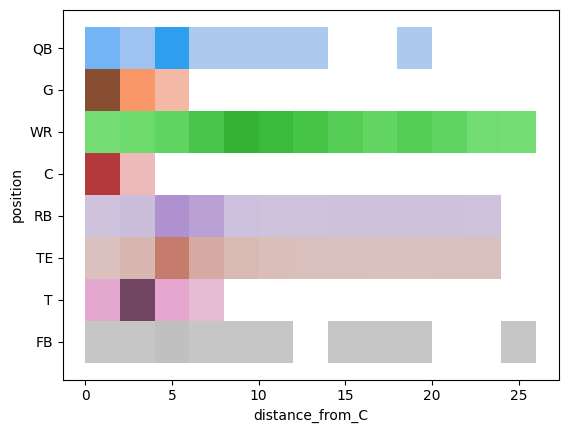

In [15]:
df = pd.read_csv('./data/tracking_week_1.csv')
play_df = pd.read_csv('./data/plays.csv')
players = pd.read_csv('./data/players.csv')

formation_df = df[df['event'] == 'ball_snap']
formation_df = formation_df.merge(play_df[['gameId', 'playId', 'possessionTeam']], on=['gameId', 'playId'], how='left')
position_df = formation_df.merge(players[['position', 'nflId']], on='nflId', how='left')

center_positions = position_df[position_df['position'] == 'C'][['gameId', 'playId', 'frameId', 'x', 'y']]
center_positions = center_positions.rename(columns={'x': 'football_x', 'y': 'football_y'})


distance_df = position_df.merge(center_positions, on=['gameId', 'playId', 'frameId'], how='left')
distance_df = distance_df[distance_df['displayName'] != 'football']

distance_df['distance_from_C'] = np.sqrt((distance_df['x'] - distance_df['football_x'])**2 + (distance_df['y'] - distance_df['football_y'])**2)

sns.histplot(
    distance_df[(distance_df['possessionTeam'] == distance_df['club'])], x="distance_from_C", y="position", hue="position", legend=False, binwidth=2
)

In [21]:
# Ok I'll try to look at some outliers for the center distance

# This was only one play where Jameis Winston lined up as a wide receiver. It's a limitation of this dataset that we can't change Jameis' position
# But it is also sort of a trick play and could perhaps be used as is.
# 1 row
# qb_outliers = distance_df[(distance_df['position'] == 'QB') & (distance_df['distance_from_C'] > 15)]

# Why would a center be more than one yard (perhaps because they are in as a tackle or guard) 
# 5 rows
# c_outliers = distance_df[(distance_df['position'] == 'C') & (distance_df['distance_from_C'] > 1)]

rb_outliers = distance_df[(distance_df['position'] == 'RB') & (distance_df['distance_from_C'] > 20)]
print(rb_outliers.shape)
rb_outliers.head()

(30, 23)


,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,...,a,dis,o,dir,event,possessionTeam,position,football_x,football_y,distance_from_C
1507,2022091200,2391,46096.0,Rashaad Penny,22,SNAP,2022-09-13 02:04:34.6,20.0,SEA,left,...,0.29,0.01,280.00,216.29,ball_snap,SEA,RB,99.58,23.66,22.572607
3712,2022091113,1812,44816.0,Leonard Fournette,146,SNAP,2022-09-12 01:34:59.4,7.0,TB,left,...,1.99,0.09,301.87,168.84,ball_snap,TB,RB,39.36,29.90,21.710525
5688,2022091108,705,43334.0,Derrick Henry,203,SNAP,2022-09-11 20:58:18.2,22.0,TEN,left,...,0.14,0.03,278.94,272.08,ball_snap,TEN,RB,100.88,29.69,20.766459
6010,2022091108,1110,43334.0,Derrick Henry,90,SNAP,2022-09-11 21:14:45.5,22.0,TEN,right,...,0.00,0.00,80.78,40.41,ball_snap,TEN,RB,71.28,29.79,20.777897
6263,2022091108,1461,43334.0,Derrick Henry,177,SNAP,2022-09-11 21:30:09.1,22.0,TEN,right,...,0.41,0.01,97.72,77.35,ball_snap,TEN,RB,29.11,23.72,21.173158
